# Truncated Skewed Levy Distribution

In [1]:
from os import write

from levy_distribution import pdf_from_cf, dump_levy, load_levy, kde_fit_levy, dump_scaled_levy, symmetric_logspace
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import gaussian_kde
import pandas as pd
from arch import arch_model

## Training data

In [2]:
dfs = pd.read_excel('../Indices_Data.xlsx', sheet_name=None)

euronext100 = dfs['Euronext100'][['Date', 'Close']]
stoxx50e = dfs['Stoxx50E'][['Date', 'Close']]
snp500 = dfs['S&P500'][['Date', 'Close']]

data = snp500.copy()
data = data[(data['Date'] > '2006-01-01') & (data['Date'] < '2017-12-31')].reset_index()

data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))*100
data['10 Days Returns'] = data['Returns'].rolling(window=10).sum()
data['210 Days Returns'] = data['Returns'].rolling(window=210).sum()
data = data.iloc[251:].reset_index()

In [3]:
print(data[['Date','Returns']])

           Date   Returns
0    2007-01-03 -0.119939
1    2007-01-04  0.122753
2    2007-01-05 -0.610317
3    2007-01-08  0.221786
4    2007-01-09 -0.051681
...         ...       ...
2764 2017-12-22 -0.045827
2765 2017-12-26 -0.105898
2766 2017-12-27  0.079063
2767 2017-12-28  0.183232
2768 2017-12-29 -0.519663

[2769 rows x 2 columns]


## Fit the Garch
The Garch model:

In [4]:
def model(returns : pd.DataFrame, omega, alpha, gamma, beta, kappa):
    t_max = len(returns)
    epsilon = np.zeros(t_max)
    sigma = np.zeros(t_max+1)

    sigma[0]= returns.std()
    
    for t in range(t_max):
        if returns[t]<0:
            leverage=1
        else:
            leverage=0
        epsilon[t] = returns[t]/sigma[t]
        sigma[t+1] = np.power(omega + alpha*np.power(np.abs(epsilon[t]),kappa)+gamma*leverage*np.power(np.abs(epsilon[t]),kappa)+beta*np.power(sigma[t],kappa), 1/kappa)
    return sigma

In [5]:
garch = arch_model(data['Returns'], p=1, q=1, o=1, power=1.76, dist='normal')
results=garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 45073776.72837777
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3206652419.0222716
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3795.577197006219
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3688.451477282945
Iteration:      5,   Func. Count:     39,   Neg. LLF: 9431.269747781098
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3685.918016514541
Iteration:      7,   Func. Count:     54,   Neg. LLF: 3683.1272848367907
Iteration:      8,   Func. Count:     60,   Neg. LLF: 3683.12225352771
Iteration:      9,   Func. Count:     67,   Neg. LLF: 3683.1044010797277
Iteration:     10,   Func. Count:     73,   Neg. LLF: 3683.1037852779145
Iteration:     11,   Func. Count:     78,   Neg. LLF: 3683.103785280225
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3683.1037852779145
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations

In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 1.8) Model Results               
==========================================================================================
Dep. Variable:                            Returns   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 1.8)   Log-Likelihood:               -3683.10
Distribution:                              Normal   AIC:                           7376.21
Method:                        Maximum Likelihood   BIC:                           7405.84
                                                    No. Observations:                 2769
Date:                            Tue, Apr 08 2025   Df Residuals:                     2768
Time:                                    20:58:50   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0263  1.466e-02      1.792  7.309e-02 [-2.458e-03,5.501e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0247  5.356e-03      4.605  4.124e-06  [1.417e-02,3.516e-02]
alpha[1]       0.0000  2.057e-02      0.000      1.000 [-4.032e-02,4.032e-02]
gamma[1]       0.2059  3.003e-02      6.858  7.000e-12      [  0.147,  0.265]
beta[1]        0.8818  1.835e-02     48.043      0.000      [  0.846,  0.918]
=============================================================================

Covariance estimator: robust
"""

In [7]:
latex = results.summary().as_latex()
with open('table.tex', 'w') as f:
    f.write(latex)

In [8]:
print(results.params)

mu          0.026274
omega       0.024663
alpha[1]    0.000000
gamma[1]    0.205948
beta[1]     0.881810
Name: params, dtype: float64


In [9]:
mean = results.params['mu']
std_dev = model(data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [10]:
data['Standardized Returns'] = (data['Returns']-mean)/std_dev[:-1]
data['Volatilities'] = std_dev[:-1]

In [11]:
kde= gaussian_kde(data['Standardized Returns'])
x_values = np.linspace(-8,8,1000)
y_kde=kde(x_values)

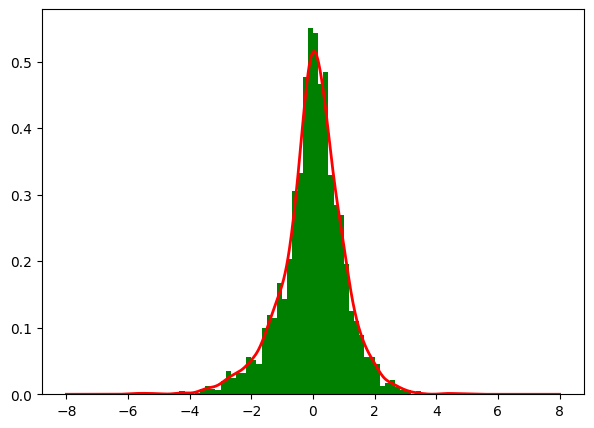

In [12]:
plt.figure(figsize=(7, 5))
plt.hist(data['Standardized Returns'], range=(-5, 5), bins=60, density=True, color='green')
plt.plot(x_values,y_kde, color='red', linewidth = 2)
plt.show()

## KDE Fit the PDF
On the standardized normal

In [13]:
n_points = 13
alpha_grid = np.linspace(1.7,1.7,1)
lam_grid = np.linspace(0.06,1.80,n_points)
beta_grid = np.linspace(-0.2,0.2,n_points)

In [14]:
kde_opt = kde_fit_levy(data['Standardized Returns'],alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid, n = 100, x_max=15, k_max=5.0, ln_2_k_points=12)

In [15]:
print(kde_opt)

[ 1.7         0.495      -0.03333333  0.05203528]


In [81]:
kde_opt[0] = 0.66  
kde_opt[1] = 0.5
kde_opt[2] = -0.03

In [84]:
x_values = np.linspace(-8, 8, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, 0, 1, kde_opt[0], kde_opt[1], kde_opt[2], k_max=15.0, ln_2_k_points=12, x_lim=25)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))

It took 1.08402681350708 seconds for 1000 evaluations


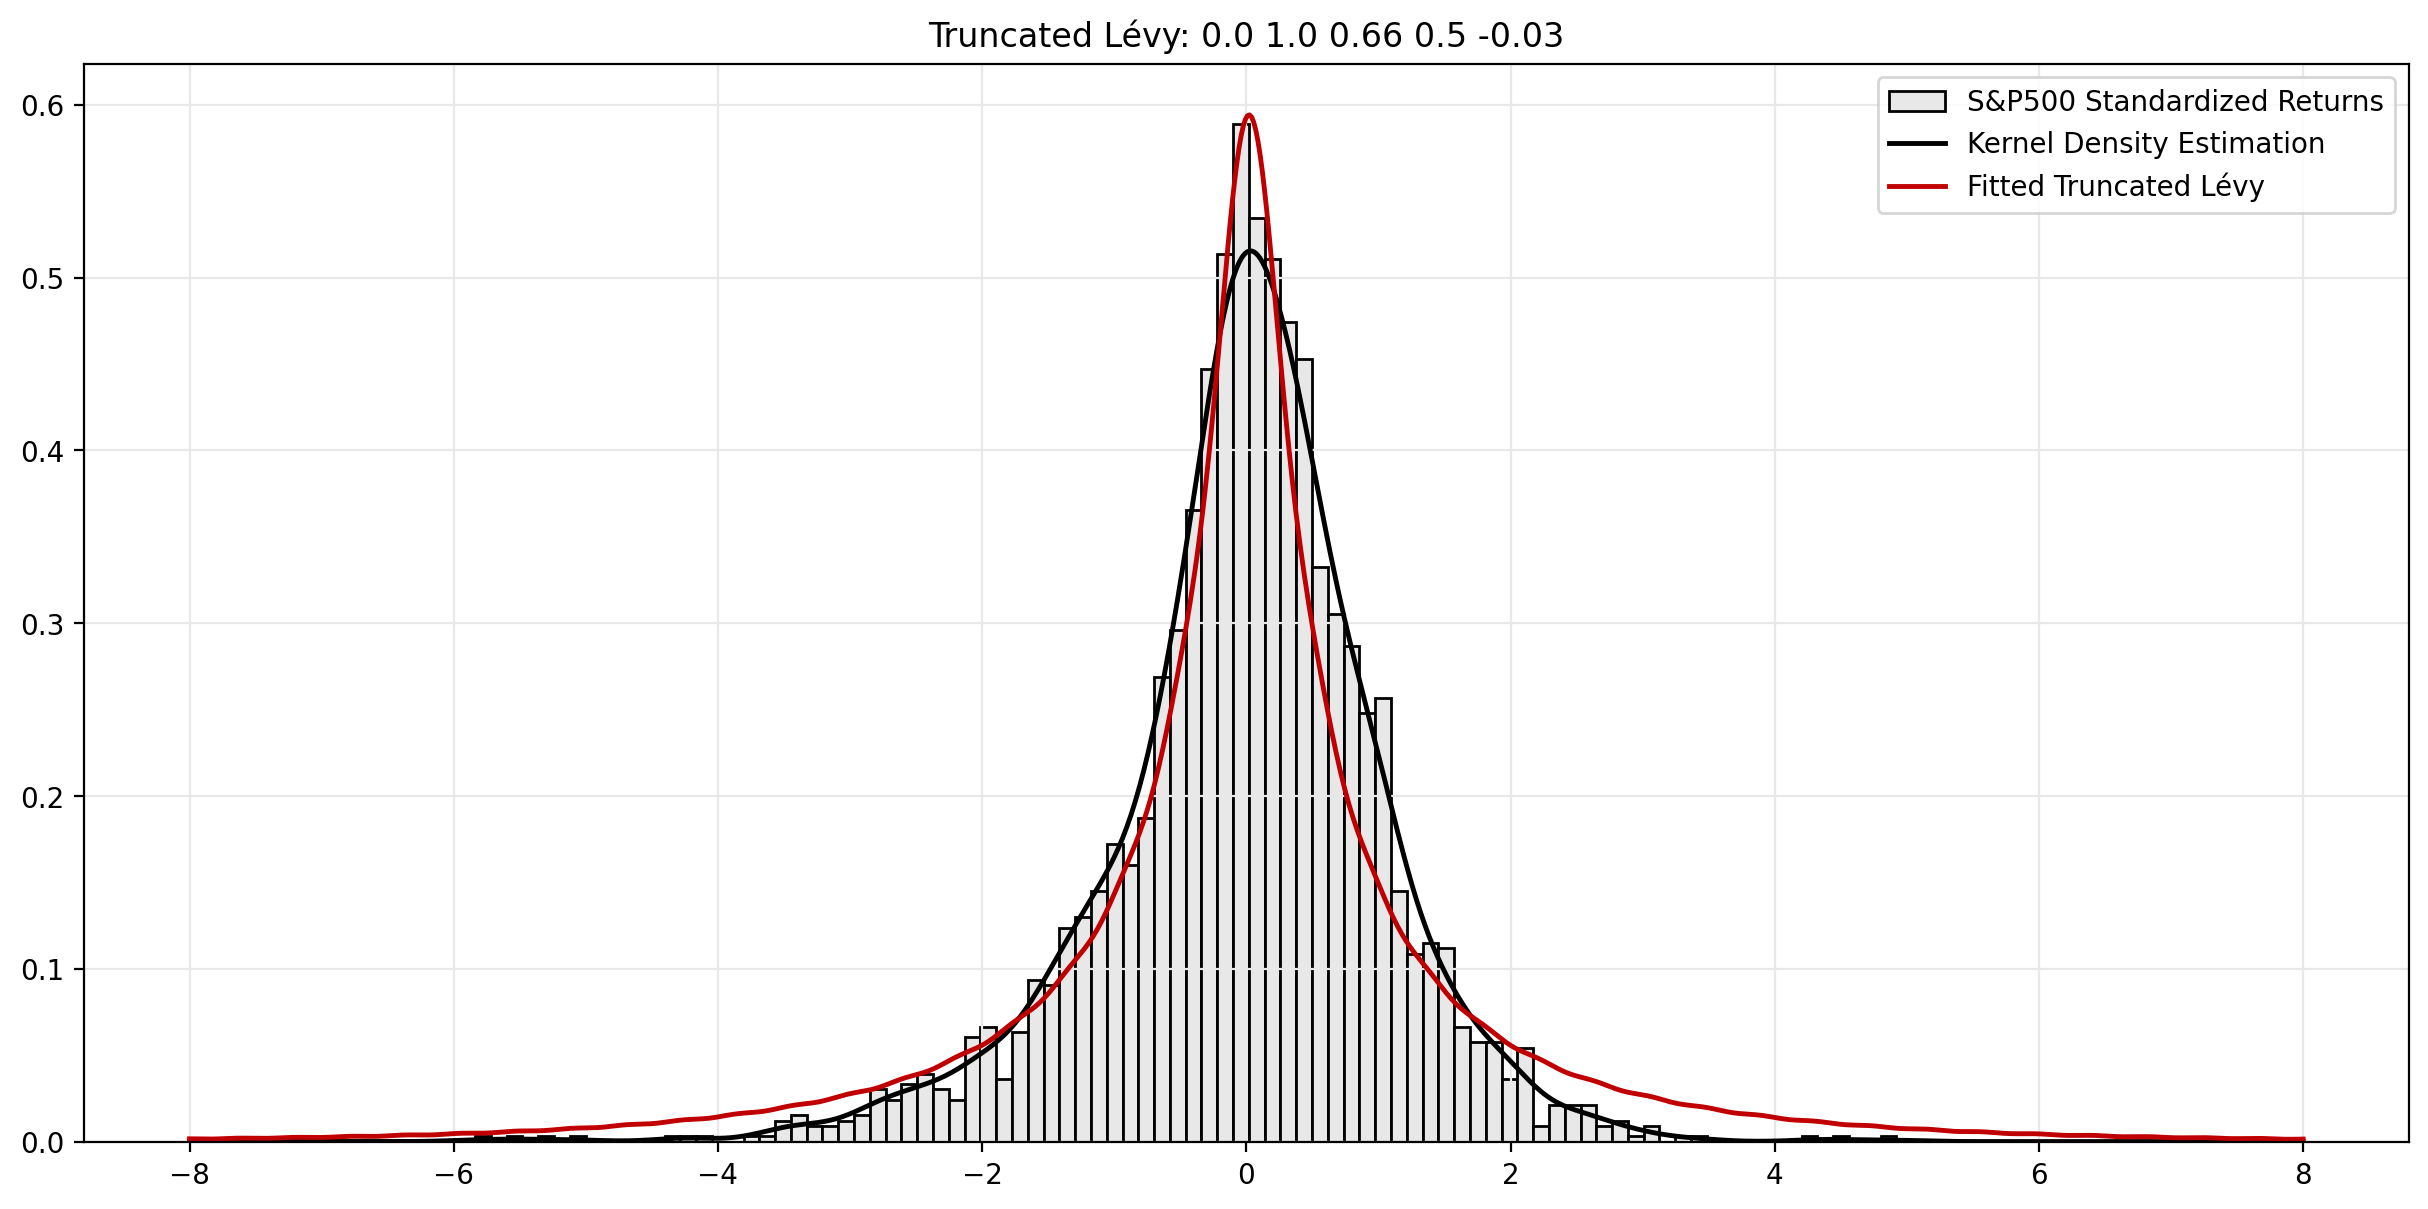

In [85]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
ax.hist(data['Standardized Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standardized Returns')
ax.plot(x_values, y_kde, label='Kernel Density Estimation', color='#000000', linewidth=1.75)
ax.plot(x_values, y_values, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)
ax.legend()
ax.set_title("Truncated Lévy: " + str(np.round(0.00,2)) + ' ' +  str(np.round(1.00,2)) + ' ' +   str(np.round(kde_opt[0],2)) + ' ' +   str(np.round(kde_opt[1],2)) + ' ' +   str(np.round(kde_opt[2],2)))

plt.show()

## Save the distribution points

In [19]:
# dump_levy(0,1,kde_opt[0],kde_opt[1],kde_opt[2],x_min=-20,x_max=20,x_points=40000,k_max=50,ln_2_k_points=15)

In [20]:
levy=load_levy('truncated_levy_0_1_0.76_1.68_-0.16.npz')

## VaR Calculation

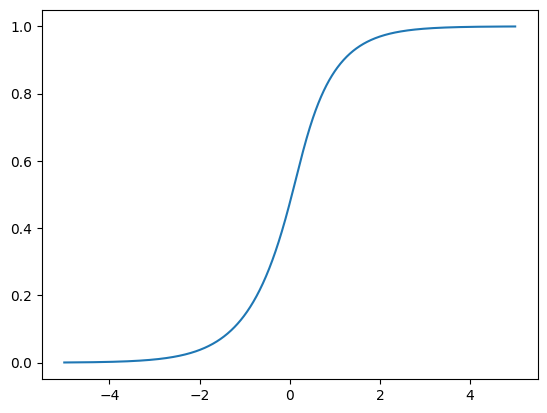

In [21]:
x = np.linspace(-5,5,1000)
y = levy.cdf(x)
plt.plot(x,y)
plt.show()

In [22]:
first_percentile = levy.ppf(0.1, loc=0.0, scale=1.0)
print(first_percentile)

-1.268163545152672


In [23]:
data['1 Day VaR'] = first_percentile*data['Volatilities']

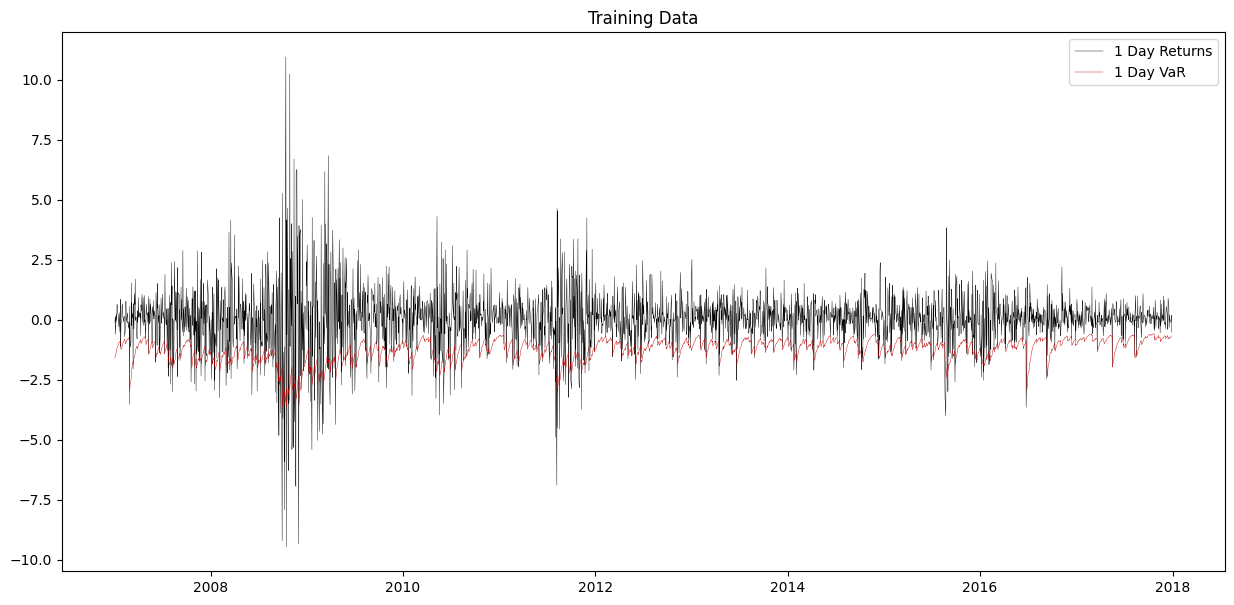

In [24]:
plt.figure(figsize=(15,7))
plt.plot(data['Date'],data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(data['Date'],data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Training Data')
plt.legend()
plt.show()

In [25]:
data['Violations']=data['1 Day VaR'] > data['Returns']
violations = data['Violations'].mean() * 100
print(violations, '%')

9.823040808956302 %


## Test Data

In [26]:
test_data= snp500.copy()
test_data = test_data[(test_data['Date'] > '2017-12-21') & (test_data['Date'] < '2024-12-31')].reset_index()
test_data['Returns'] = np.log(test_data['Close'] / test_data['Close'].shift(1)) * 100
test_data['10 Days Returns'] = test_data['Returns'].rolling(window=10).sum()
test_data = test_data.dropna().reset_index()

In [27]:
test_data[['Date','Returns','10 Days Returns']]

,Date,Returns,10 Days Returns
0,2018-01-09,0.130208,2.500759
1,2018-01-10,-0.111285,2.495372
2,2018-01-11,0.700903,3.117211
3,2018-01-12,0.672693,3.606672
4,2018-01-16,-0.353071,3.773264
...,...,...,...
1750,2024-12-23,0.726085,-1.310084
1751,2024-12-24,1.098223,0.084967
1752,2024-12-26,-0.040574,-0.768869
1753,2024-12-27,-1.111730,-1.337727


In [28]:
mean = results.params['mu']
test_std_dev = model(test_data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [29]:
test_std_dev

array([1.24877628, 1.17509262, 1.10878315, ..., 1.3508274 , 1.33729651,
       1.3226579 ])

In [30]:
test_data['Standardized Returns'] = (test_data['Returns']-mean)/test_std_dev[:-1]
test_data['Volatilities'] = test_std_dev[:-1]
test_data['1 Day VaR'] = first_percentile * test_data['Volatilities']
test_data['Violations'] = test_data['1 Day VaR'] > test_data['Returns']
test_violations=test_data['Violations'].mean()*100

In [31]:
test_data

,level_0,index,Date,Close,Returns,10 Days Returns,Standardized Returns,Volatilities,1 Day VaR,Violations
0,10,22611,2018-01-09,2751.290039,0.130208,2.500759,0.083229,1.248776,-1.583653,False
1,11,22612,2018-01-10,2748.229980,-0.111285,2.495372,-0.117062,1.175093,-1.490210,False
2,12,22613,2018-01-11,2767.560059,0.700903,3.117211,0.608441,1.108783,-1.406118,False
3,13,22614,2018-01-12,2786.239990,0.672693,3.606672,0.618039,1.045919,-1.326397,False
4,14,22615,2018-01-16,2776.419922,-0.353071,3.773264,-0.383952,0.988001,-1.252947,False
...,...,...,...,...,...,...,...,...,...,...
1750,1760,24361,2024-12-23,5974.069824,0.726085,-1.310084,0.427613,1.636552,-2.075416,False
1751,1761,24362,2024-12-24,6040.040039,1.098223,0.084967,0.698873,1.533827,-1.945143,False
1752,1762,24363,2024-12-26,6037.589844,-0.040574,-0.768869,-0.046464,1.438695,-1.824501,False
1753,1763,24364,2024-12-27,5970.839844,-1.111730,-1.337727,-0.842450,1.350827,-1.713070,False


In [32]:
print(test_violations)

9.515669515669515


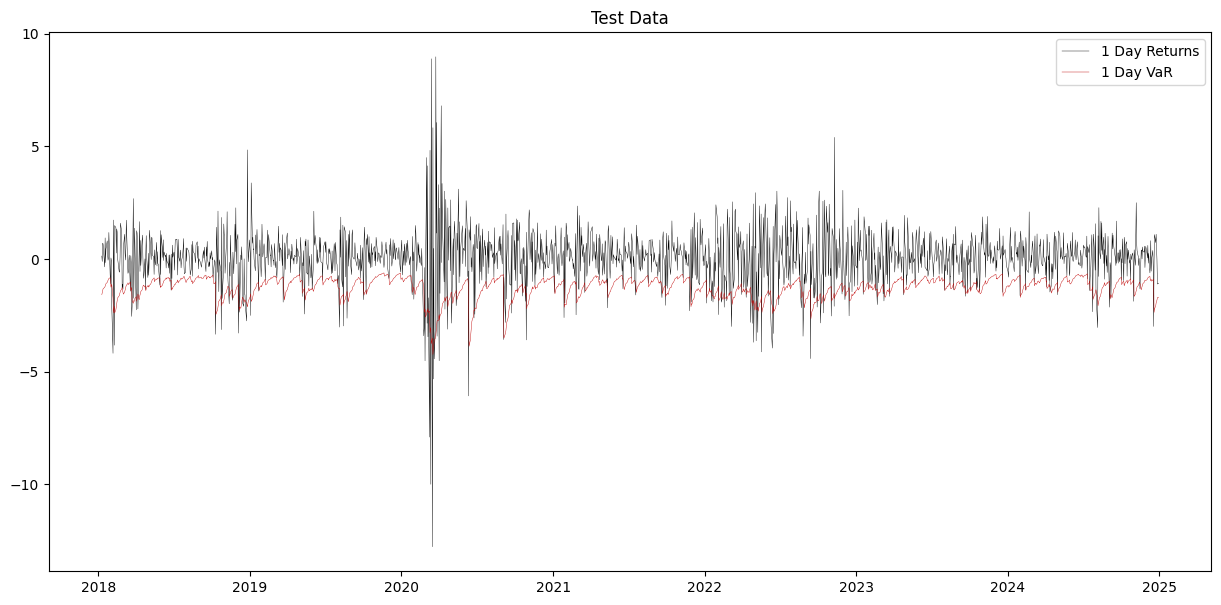

In [33]:
plt.figure(figsize=(15,7))
plt.plot(test_data['Date'],test_data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(test_data['Date'],test_data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Test Data')
plt.legend()
plt.show()

# Scaling to 10 Days VaR

Only for plotting

In [34]:
N = 10
ten_days_returns = np.array(data['Returns'].copy().rolling(window=N).sum().dropna().iloc[::N].reset_index(drop=True))
print(ten_days_returns)

[  0.86489076   0.53122237   1.17919614  -3.64781045  -0.77912819
   2.14942849   2.10901307   2.7976776    0.78536029   0.65396516
  -0.4370462   -0.75693975   0.82318159   0.06090667  -2.29815674
  -2.02412428   1.72436673   3.78145283   0.68825584   0.10711559
   0.52675732  -5.21980031  -0.05849644   1.26365725  -0.6687169
  -4.30087567  -3.88380497  -0.99147032   2.28382256  -5.30102262
   1.28981075   2.59031784   2.05653614   0.63593305  -0.23854183
  -2.44437251  -3.19222496  -5.1072472    0.61218283  -0.87604756
   2.34144649  -0.07980812  -5.13765001  -3.97033534 -15.58797485
  -5.93410144  -4.51948626  -4.73345211   4.76570433  -3.51854124
   2.52500775  -6.23044087   3.9056576  -11.790662    -7.17646955
  11.35371406   1.16301086   3.37564453   8.62435392  -1.7619829
   4.22506286  -2.58931472  -2.41913201   4.787502     4.88721695
   1.66807408   2.44377941   1.9641883    1.29149036   1.23507055
  -0.86229065   2.41952943   1.19675096  -1.30109918   2.3603404
   2.09502883

In [35]:
garch = arch_model(ten_days_returns, p=1, q=1, o=1, power=1.76, dist='normal')
results=garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1031.898675067468
Iteration:      2,   Func. Count:     18,   Neg. LLF: 851.3341845313005
Iteration:      3,   Func. Count:     26,   Neg. LLF: 981.0279870088971
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1021.8561793197716
Iteration:      5,   Func. Count:     40,   Neg. LLF: 659.0079658761358
Iteration:      6,   Func. Count:     46,   Neg. LLF: 658.9308911800598
Iteration:      7,   Func. Count:     52,   Neg. LLF: 658.8973184451352
Iteration:      8,   Func. Count:     58,   Neg. LLF: 658.868049605682
Iteration:      9,   Func. Count:     64,   Neg. LLF: 658.8598437940268
Iteration:     10,   Func. Count:     70,   Neg. LLF: 658.8576791587631
Iteration:     11,   Func. Count:     76,   Neg. LLF: 658.8575137617008
Iteration:     12,   Func. Count:     82,   Neg. LLF: 658.8575067304891
Iteration:     13,   Func. Count:     87,   Neg. LLF: 658.8575067307748
Optimization terminated successfully    (Exit mode 0)
          

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 1.8) Model Results               
==========================================================================================
Dep. Variable:                                  y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 1.8)   Log-Likelihood:               -658.858
Distribution:                              Normal   AIC:                           1327.72
Method:                        Maximum Likelihood   BIC:                           1345.82
                                                    No. Observations:                  276
Date:                            Tue, Apr 08 2025   Df Residuals:                      275
Time:                                    20:59:25   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2532      0.186      1.362      0.173 [ -0.111,  0.618]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6206      0.257      2.412  1.585e-02    [  0.116,  1.125]
alpha[1]   4.0865e-12      0.421  9.711e-12      1.000    [ -0.825,  0.825]
gamma[1]       0.3884      0.238      1.630      0.103 [-7.853e-02,  0.855]
beta[1]        0.7269      0.228      3.191  1.418e-03    [  0.280,  1.173]
===========================================================================

Covariance estimator: robust
"""

In [37]:
ten_days_mean = results.params['mu']
ten_days_std_dev = model(ten_days_returns,omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)
ten_days_std_returns = (ten_days_returns -ten_days_mean)/ten_days_std_dev[:-1]

In [38]:
alpha = kde_opt[0]
lamb = kde_opt[1]
beta = kde_opt[2]

In [102]:
x = np.linspace(-10,10,200)
mu = 0.0
c = 1.0
alpha = 0.765
lamb=1.67
beta=-0.155

N_alpha = N**(alpha)
print(N_alpha)
y = pdf_from_cf(x,mu,N_alpha*c,alpha,lamb,beta,x_lim=50,k_max=15,ln_2_k_points=15)
print(y)

19.939398511371774
[0.00187589 0.00201631 0.00216631 0.00232644 0.0024973  0.00267951
 0.00287371 0.00308059 0.00330084 0.0035352  0.00378442 0.00404928
 0.00433062 0.00462926 0.00494609 0.00528199 0.00563791 0.00601478
 0.0064136  0.00683535 0.00728108 0.00775182 0.00824864 0.00877262
 0.00932487 0.00990651 0.01051864 0.01116241 0.01183895 0.0125494
 0.01329488 0.01407652 0.01489543 0.0157527  0.01664941 0.0175866
 0.01856528 0.01958641 0.02065092 0.02175967 0.02291348 0.02411309
 0.02535915 0.02665225 0.02799288 0.02938143 0.03081818 0.0323033
 0.03383683 0.03541868 0.03704861 0.03872625 0.04045106 0.04222232
 0.04403917 0.04590054 0.04780519 0.04975168 0.05173836 0.05376341
 0.05582477 0.05792017 0.06004715 0.062203   0.06438483 0.0665895
 0.06881367 0.07105381 0.07330614 0.07556671 0.07783137 0.08009578
 0.08235543 0.08460563 0.08684155 0.08905823 0.09125058 0.09341339
 0.09554139 0.09762924 0.09967153 0.10166285 0.10359779 0.10547095
 0.10727699 0.10901065 0.11066674 0.11224024 0.

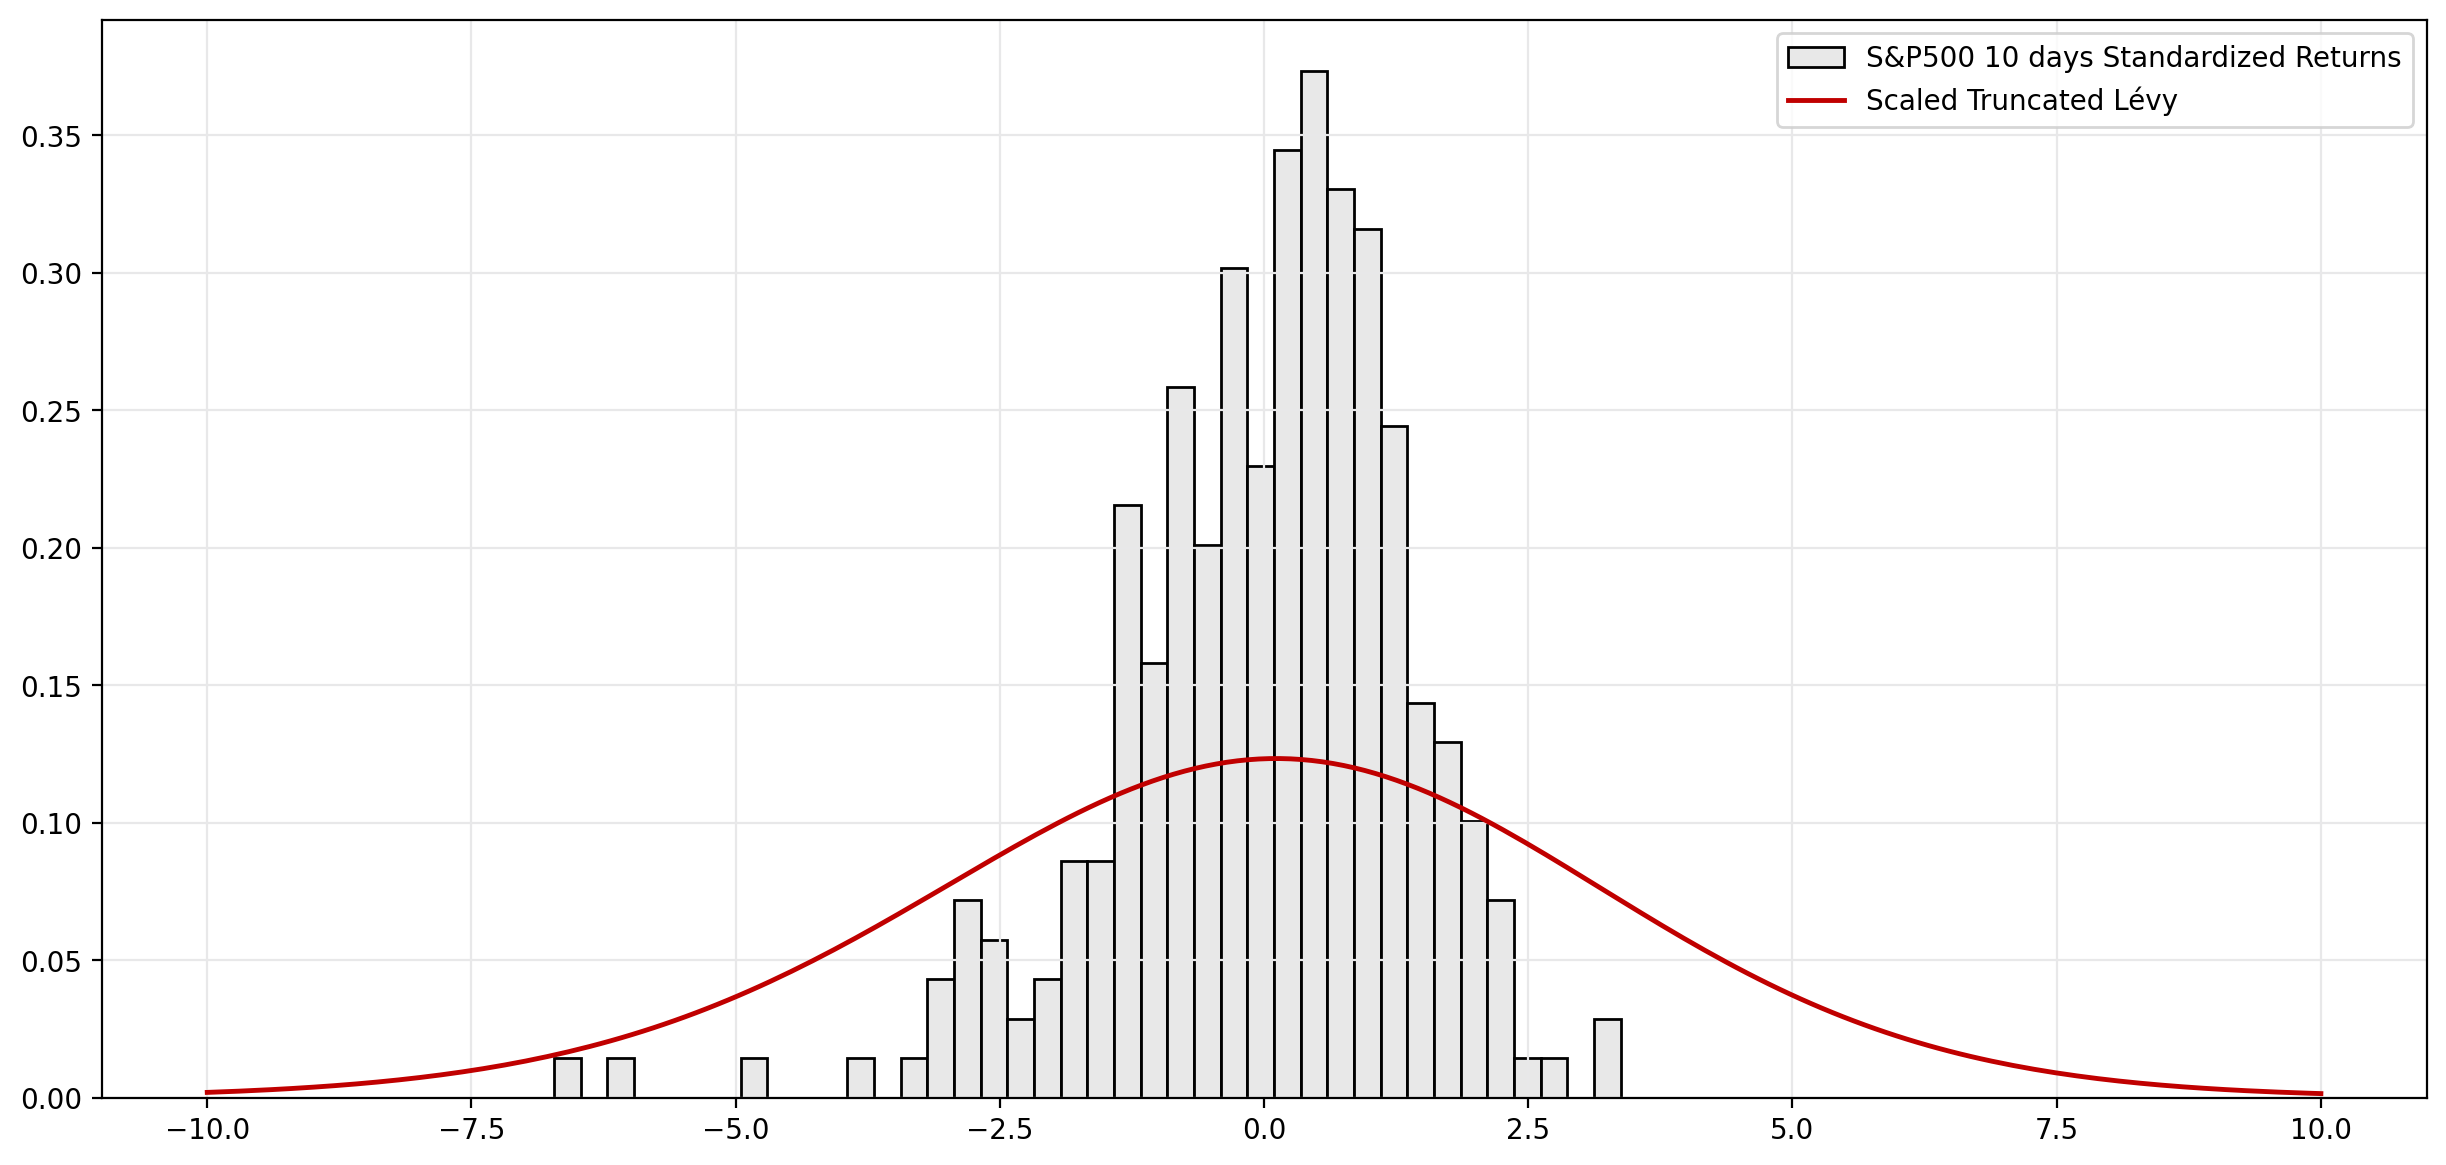

In [103]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
ax.hist(ten_days_std_returns, bins=40, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 10 days Standardized Returns')
ax.plot(x, y, label='Scaled Truncated Lévy', color='#C00000', linewidth=1.75)
ax.legend()
plt.show()

## Real thing

In [41]:
# dump_scaled_levy(0,1,kde_opt[0],kde_opt[1],kde_opt[2], days=10,x_min=-20,x_max=20,x_points=40000,k_max=50,ln_2_k_points=15)

In [150]:
scaled_levy=load_levy('./scaled_truncated_levy_0_1_0.76_1.68_-0.16.npz')

In [218]:
scaled_first_percentile = scaled_levy.ppf(0.1)
print(scaled_first_percentile)

-4.265696672935876


In [219]:
print(scaled_first_percentile)
print(first_percentile*np.sqrt(10))

-4.265696672935876
-4.010285248276229


In [220]:
data['10 Days VaR'] = scaled_first_percentile*data['Volatilities'].shift(9)

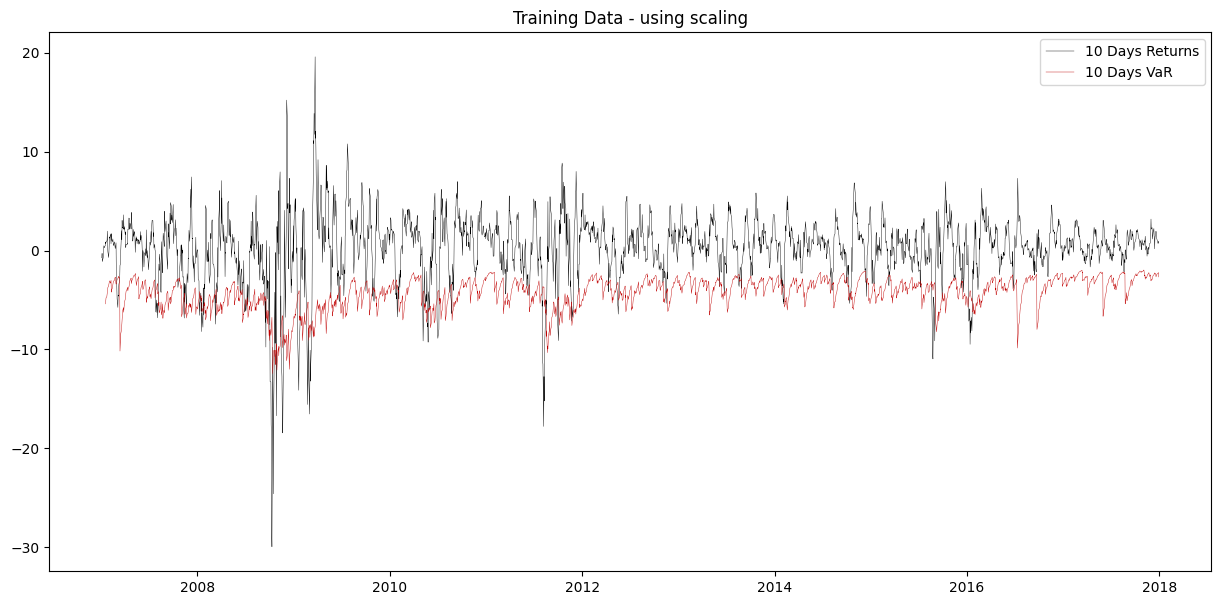

In [221]:
plt.figure(figsize=(15,7))
plt.plot(data['Date'],data['10 Days Returns'],label='10 Days Returns', color='black',linewidth = 0.3)
plt.plot(data['Date'],data['10 Days VaR'],label='10 Days VaR', color = '#C00000', linewidth = 0.3)
plt.title('Training Data - using scaling')
plt.legend()
plt.show()

In [222]:
data['10 Days Violations'] = data['10 Days VaR'] > data['10 Days Returns']
biweekly_violations=data['10 Days Violations'].mean()*100
print(np.round(biweekly_violations,2),'%')

6.68 %


In [223]:
test_data['10 Days VaR'] = scaled_first_percentile*test_data['Volatilities'].shift(9)
test_data

,level_0,index,Date,Close,Returns,10 Days Returns,Standardized Returns,Volatilities,1 Day VaR,Violations,10 Days VaR,10 Days Violations
0,10,22611,2018-01-09,2751.290039,0.130208,2.500759,0.083229,1.248776,-1.583653,False,NaN,False
1,11,22612,2018-01-10,2748.229980,-0.111285,2.495372,-0.117062,1.175093,-1.490210,False,NaN,False
2,12,22613,2018-01-11,2767.560059,0.700903,3.117211,0.608441,1.108783,-1.406118,False,NaN,False
3,13,22614,2018-01-12,2786.239990,0.672693,3.606672,0.618039,1.045919,-1.326397,False,NaN,False
4,14,22615,2018-01-16,2776.419922,-0.353071,3.773264,-0.383952,0.988001,-1.252947,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1750,1760,24361,2024-12-23,5974.069824,0.726085,-1.310084,0.427613,1.636552,-2.075416,False,-3.203504,False
1751,1761,24362,2024-12-24,6040.040039,1.098223,0.084967,0.698873,1.533827,-1.945143,False,-3.183768,False
1752,1762,24363,2024-12-26,6037.589844,-0.040574,-0.768869,-0.046464,1.438695,-1.824501,False,-3.042226,False
1753,1763,24364,2024-12-27,5970.839844,-1.111730,-1.337727,-0.842450,1.350827,-1.713070,False,-3.305834,False


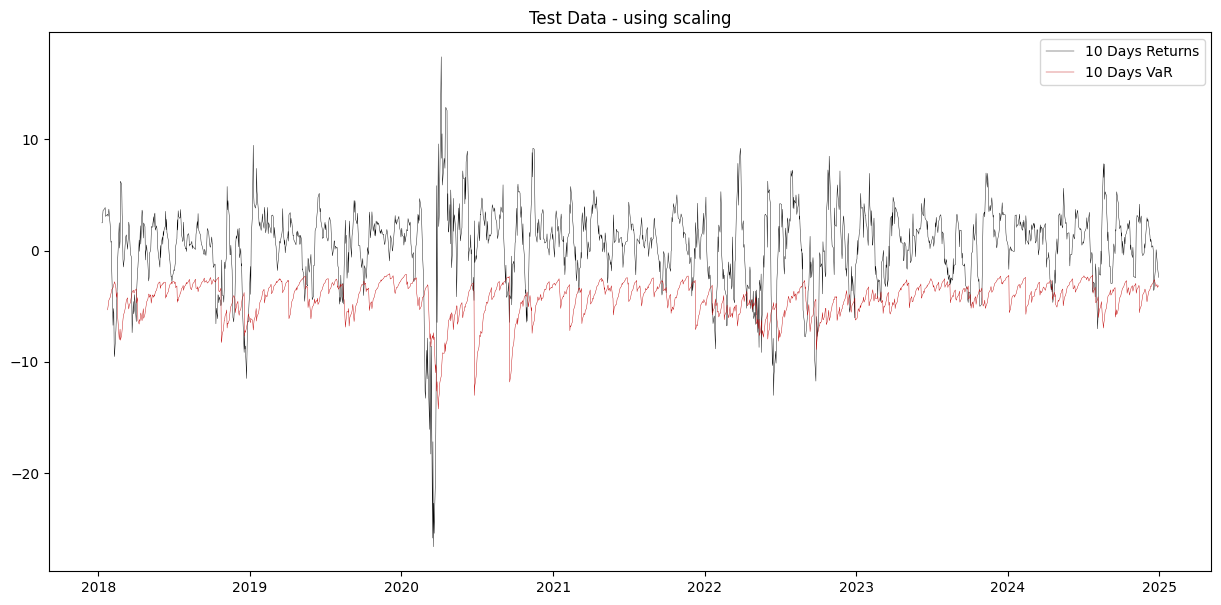

In [224]:
plt.figure(figsize=(15,7))
plt.plot(test_data['Date'],test_data['10 Days Returns'],label='10 Days Returns', color='black',linewidth = 0.3)
plt.plot(test_data['Date'],test_data['10 Days VaR'],label='10 Days VaR', color = '#C00000', linewidth = 0.3)
plt.title('Test Data - using scaling')
plt.legend()
plt.show()

In [225]:
test_data['10 Days Violations'] = test_data['10 Days VaR'] > test_data['10 Days Returns']
biweekly_violations=test_data['10 Days Violations'].mean()*100
print(np.round(biweekly_violations,2),'%')

8.66 %


# Comparing with Montecarlo

In [226]:
from arch.univariate import ConstantMean, GARCH
import arch_distribution
import importlib

importlib.reload(arch_distribution)
Levy = arch_distribution.CustomArchDistribution('truncated_levy_0_1_0.76_1.68_-0.16.npz')

am = ConstantMean(data['Returns'])
am.volatility = GARCH(1, 1, 1)
am.distribution = Levy

In [52]:
res= am.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 13542881186.15475
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1057747192.2910393
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3872.3062613151255
Iteration:      4,   Func. Count:     32,   Neg. LLF: 4007.1735436750178
Iteration:      5,   Func. Count:     39,   Neg. LLF: 3701.972092482043
Iteration:      6,   Func. Count:     46,   Neg. LLF: 4050.7748608210513
Iteration:      7,   Func. Count:     54,   Neg. LLF: 3690.317351653254
Iteration:      8,   Func. Count:     60,   Neg. LLF: 3690.2929498700755
Iteration:      9,   Func. Count:     66,   Neg. LLF: 3690.286695200275
Iteration:     10,   Func. Count:     72,   Neg. LLF: 3690.286484240625
Iteration:     11,   Func. Count:     78,   Neg. LLF: 3690.2864673399085
Iteration:     12,   Func. Count:     84,   Neg. LLF: 3690.2864661613266
Iteration:     13,   Func. Count:     89,   Neg. LLF: 3690.286466162266
Optimization terminated successfully    (Exit mode 0)
   

In [53]:
forecasts=am.forecast(method='bootstrap',params=res.params, horizon=500)

In [54]:
forecasts.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
2768,0.282818,0.300715,0.315819,0.331652,0.351462,0.368465,0.39892,0.417928,0.439554,0.463874,...,2.171951,2.108224,2.065344,2.022089,2.030523,2.21884,2.155226,2.234431,2.181566,2.136014


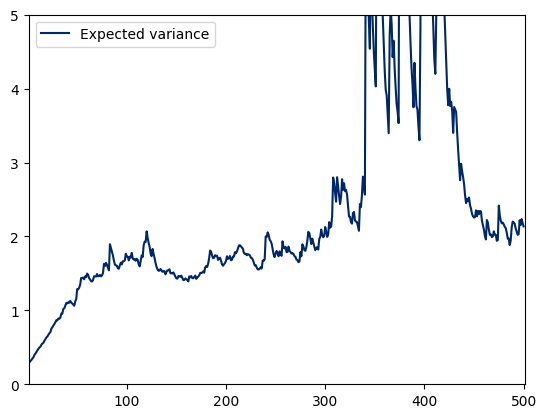

In [55]:
sims = forecasts.simulations
x = np.arange(1, 501)
line = plt.plot(x, forecasts.variance.iloc[-1].values, color="#002868")
line[0].set_label("Expected variance")
plt.gca().set_xlim(1, 501)
plt.gca().set_ylim(0, 5)

legend = plt.legend()

In [56]:
def simulate_model(sigma0, omega, alpha, gamma, beta, kappa, t_max,seed):
    np.random.seed(seed=seed)
    sigma = np.zeros(t_max+1)
    epsilon = levy.rvs(size=t_max)
    sigma[0]=sigma0
    for t in range(t_max):
        if epsilon[t]<0:
            leverage=1
        else:
            leverage=0
        sigma[t+1] = np.power(omega + alpha*np.power(np.abs(epsilon[t]),kappa)+gamma*leverage*np.power(np.abs(epsilon[t]),kappa)+beta*np.power(sigma[t],kappa), 1/kappa)
    return sigma
    

In [57]:
T=10
N=50
seed=np.random.randint(100*N,size=N)
sigma = np.zeros((N,T+1))
sigma0=1
for j in range(N):
    sigma[j] = simulate_model(sigma0=sigma0,omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76, t_max=T, seed=seed[j])


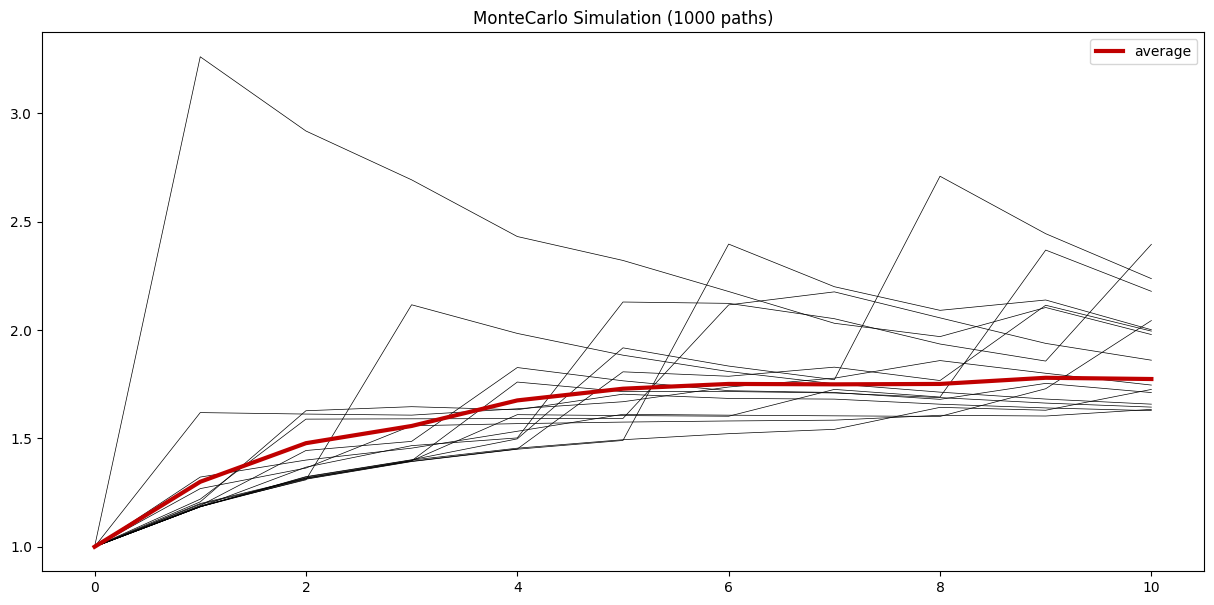

In [58]:
x = np.arange(T+1)
plt.figure(figsize=(15,7))
for j in range(15):
    plt.plot(x,sigma[j], color='black', linewidth=0.5)
    
plt.plot(x,sigma.mean(axis=0),label = 'average',color='#C00000', linewidth=3)
plt.title('MonteCarlo Simulation (1000 paths)')
plt.legend()
plt.show()

In [59]:
def montecarlo(sigma0, days, paths):
    sigma = np.zeros((paths,days+1))
    for j in range(paths):
        sigma[j] = simulate_model(sigma0=sigma0,omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76, t_max=days, seed=seed[j])
    return sigma.mean(axis=0)[-1]

In [60]:
#test_data['Montecarlo 10 Days Volatilities'] = test_data['Volatilities'].apply(lambda x: montecarlo(x,days=10,paths=50))[:-1]

KeyboardInterrupt: 

In [ ]:
#test_data['Montecarlo 10 Days VaR'] = scaled_first_percentile*test_data['Montecarlo 10 Days Volatilities']
#test_data['Montecarlo 10 Days Violations'] = test_data['Montecarlo 10 Days VaR'] > test_data['10 Days Returns']
#biweekly_violations=test_data['Montecarlo 10 Days Violations'].mean()*100
#print(np.round(biweekly_violations,2),'%')